<a href="https://colab.research.google.com/github/NadiaThan/Brain-Tumor-Classification-DataSet/blob/master/Copy_of_Brain_Cancer_Classification_%7C_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
orvile_pmram_bangladeshi_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/pmram-bangladeshi-brain-cancer-mri-dataset')

print('Data source import complete.')


Data source import complete.


# Brain Cancer Classification

Muh Amri Sidiq

## Introduction

The PMRAM: Bangladeshi Brain Cancer - MRI Dataset is a significant resource designed to assist researchers and practitioners in the field of medical imaging, particularly for brain cancer research. This dataset contains a comprehensive collection of Magnetic Resonance Imaging (MRI) images sourced from hospitals across Bangladesh 🏥, providing a diverse and representative sample that is essential for accurate model development and testing.

The dataset includes a total of 6000 MRI images, divided into four distinct classes with 1500 images per class:

Glioma 🧠

Meningioma 🧠

Pituitary 🧠

No Tumor 🚫🧠

Originally composed of 1600 raw images (400 per class), the dataset has been augmented to its current size, ensuring a broad and robust sample for training machine learning models. All images have been resized to a uniform resolution of 512×512 pixels, making them suitable for various image processing and machine learning applications.

Obtaining high-quality medical imaging data, particularly for brain cancer, can be challenging due to privacy concerns, limited availability, and the complexity of the images. The PMRAM dataset addresses this challenge by providing a substantial and diverse collection of MRI scans. Additionally, the dataset’s creation involved the collaboration of four leading medical professionals, ensuring both the accuracy and reliability of the data. As such, it serves as a dependable resource for developing diagnostic tools and advancing research in brain cancer detection and treatment.

## Import Library

Building a robust Knee Osteoarthritis classification model using TensorFlow and Keras. Incorporating deep learning techniques with VGG19, convolutional layers, regularization, and advanced optimization strategies for enhanced performance

In [6]:
import os
import cv2
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.metrics import AUC, Precision
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from PIL import Image

## Load Image

Loading and preprocessing the dataset for Brain Cancer classification

In [7]:
dataset_path = "/content/drive/MyDrive/DATA SCIENCE/DATA RESOURCE/PMRAM/PMRAM Bangladeshi Brain Cancer - MRI Dataset/PMRAM Bangladeshi Brain Cancer - MRI Dataset/Augmented Data/Augmented"

# List main directory
print("Main Folder:", os.listdir(dataset_path))

print("\nClass in Augmented:", os.listdir(dataset_path))

Main Folder: ['512Pituitary', '512Meningioma', '512Normal', '512Glioma']

Class in Augmented: ['512Pituitary', '512Meningioma', '512Normal', '512Glioma']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check sample data

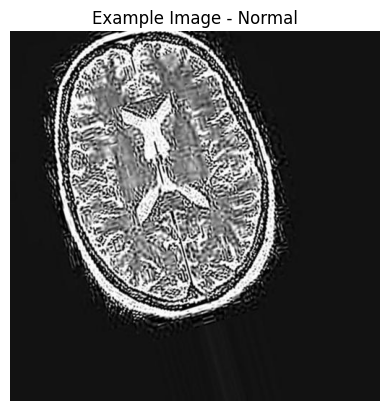

In [8]:
normal_class_path = os.path.join(dataset_path, "512Normal")
sample_image_file = os.listdir(normal_class_path)[0]
sample_image_path = os.path.join(normal_class_path, sample_image_file)

# Baca dan tampilkan gambar
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis("off")
plt.title("Example Image - Normal")
plt.show()

## Preprocessing Data

Preparing the dataset for training Loading images efficiently with TensorFlow, ensuring proper class distribution, and setting up batches for smooth model training

In [9]:
tf.config.set_visible_devices([], 'GPU')

batch_size = 32
img_size = (224, 224)
seed = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",         # ini bagian validasi
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 6004 files belonging to 4 classes.
Using 4804 files for training.
Found 6004 files belonging to 4 classes.
Using 1200 files for validation.
Found 6004 files belonging to 4 classes.
Using 1200 files for validation.


In [10]:
label_map = {
    '512Glioma': 0,
    '512Meningioma': 1,
    '512Normal': 2,
    '512Pituitary': 3
}

print("Class Label:", train_ds.class_names)
print("Class Label:", val_ds.class_names)
print("Class Label:", test_ds.class_names)

print("\nLabel train with Mapping:")
for class_name in train_ds.class_names:
    print(f"{class_name}: {label_map[class_name]}")

print("\nLabel validation with Mapping:")
for class_name in val_ds.class_names:
    print(f"{class_name}: {label_map[class_name]}")

print("\nLabel test with Mapping:")
for class_name in test_ds.class_names:
    print(f"{class_name}: {label_map[class_name]}")

Class Label: ['512Glioma', '512Meningioma', '512Normal', '512Pituitary']
Class Label: ['512Glioma', '512Meningioma', '512Normal', '512Pituitary']
Class Label: ['512Glioma', '512Meningioma', '512Normal', '512Pituitary']

Label train with Mapping:
512Glioma: 0
512Meningioma: 1
512Normal: 2
512Pituitary: 3

Label validation with Mapping:
512Glioma: 0
512Meningioma: 1
512Normal: 2
512Pituitary: 3

Label test with Mapping:
512Glioma: 0
512Meningioma: 1
512Normal: 2
512Pituitary: 3


## Modeling

In [11]:
# Define the input layer
input_layer = keras.Input(shape=(224, 224, 3))  # ✅ Add input layer

# Load VGG19 as the base model with input from input_layer
base_model = VGG19(
    include_top=False,  # Excludes built-in FC layer
    weights="imagenet",  # Use Weight pre-trained From ImageNet
    input_tensor=input_layer  # ✅ Use input_tensor
)
base_model.trainable = False  # Freeze the initial layer during initial training

# Build a new model on top of VGG19
x = base_model.output
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2)) (x)
x = layers.GlobalAveragePooling2D()(x)  # Aligning features before classification
x = layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
output_layer = layers.Dense(4, activation="softmax")(x)  # According to the number of classes

# Define the model
model = keras.Model(inputs=input_layer, outputs=output_layer)  # ✅ Use Model API

# Optimizer
optimizer = SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

# Compile Model
model.compile(
    optimizer=optimizer,  # Small LR for stability
    loss="sparse_categorical_crossentropy",  # Because the One-Hot label is Encoded
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, min_lr=1e-7),
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
]

# Display model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 223, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 223, 223, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 223, 223, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 111, 111, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 111, 111, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 55, 55, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 27, 27, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 6, 6, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,177,252 (76.97 MB)

 Trainable params: 152,548 (595.89 KB)

 Non-trainable params: 20,024,704 (76.39 MB)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/3
 20/151 ━━━━━━━━━━━━━━━━━━━━ 53:03 24s/step - accuracy: 0.4804 - loss: 1.6969

In [ ]:
# Plot history training
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

## Prediction

In [ ]:
class_names = train_ds.class_names

for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label = labels[i].numpy()

        plt.title(f"Pred: {class_names[pred_labels[i]]}\nTrue: {class_names[true_label]}")
        plt.axis("off")
    plt.show()

## Conclussion

Accuracy model is 93%

## Referance

1. https://www.analyticsvidhya.com/

2. https://xbe.at/

3. https://www.tensorflow.org/guide/keras

## Contact

[Linkedin](http://linkedin.com/in/muh-amri-sidiq)